In [20]:
from __future__ import annotations
from flamekit.datasets import SEMDataset
from flamekit.io_fronts import Case
from mpi4py import MPI
from pathlib import Path
import matplotlib.pyplot as plt

In [27]:

TIME_STEP = 200
MULTI_TIME_STEP = True
TIME_STEP_START = 270
TIME_STEP_END = 301
PHI = 0.40
LAT_SIZE = "025"
T_REF = 300
P_REF = 1e05

COMP_VEL_JACOBIAN = True
COMP_VEL_HESSIAN = False
COMP_T_GRAD = True
COMP_CURV_GRAD = True
COMP_REACTION_RATES = True
COMP_LOCAL_VEL_JACOBIAN = True

ISOLEVELS = [2, 2.5, 3, 3.5, 4, 4.5]
N_ISOLEVELS = len(ISOLEVELS)
POST = True

DATA_BASE_DIR = Path("data")
ISOCONTOUR_BASE_DIR = Path("../isocontours")

FILE_NAME = "po_postPremix" if POST else "premix"

2025-12-21 11:00:52,396 - Mesh - INFO - Initializing empty Mesh object.
2025-12-21 11:00:52,398 - Field - INFO - Initializing empty Field object
2025-12-21 11:00:52,399 - pynekread - INFO - Reading file: ../data\phi0.40\h400x200_ref/po_postPremix0.f00001
2025-12-21 11:00:52,497 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-12-21 11:00:52,497 - Mesh - INFO - Initializing common attributes.
2025-12-21 11:00:52,499 - Mesh - INFO - Getting vertices
2025-12-21 11:00:52,517 - Mesh - INFO - Getting edge centers
2025-12-21 11:00:52,673 - Mesh - INFO - Facet centers not available for 2D
2025-12-21 11:00:52,674 - Mesh - INFO - Mesh object initialized.
2025-12-21 11:00:52,674 - Mesh - INFO - Mesh data is of type: float64
2025-12-21 11:00:52,674 - Mesh - INFO - Elapsed time: 0.17789220000850037s
2025-12-21 11:00:52,675 - pynekread - INFO - Reading field data
2025-12-21 11:00:52,675 - pynekread - INFO - Overwriting fld object
2025-12-21 11:00:54,644 - pynekread - INFO - File re

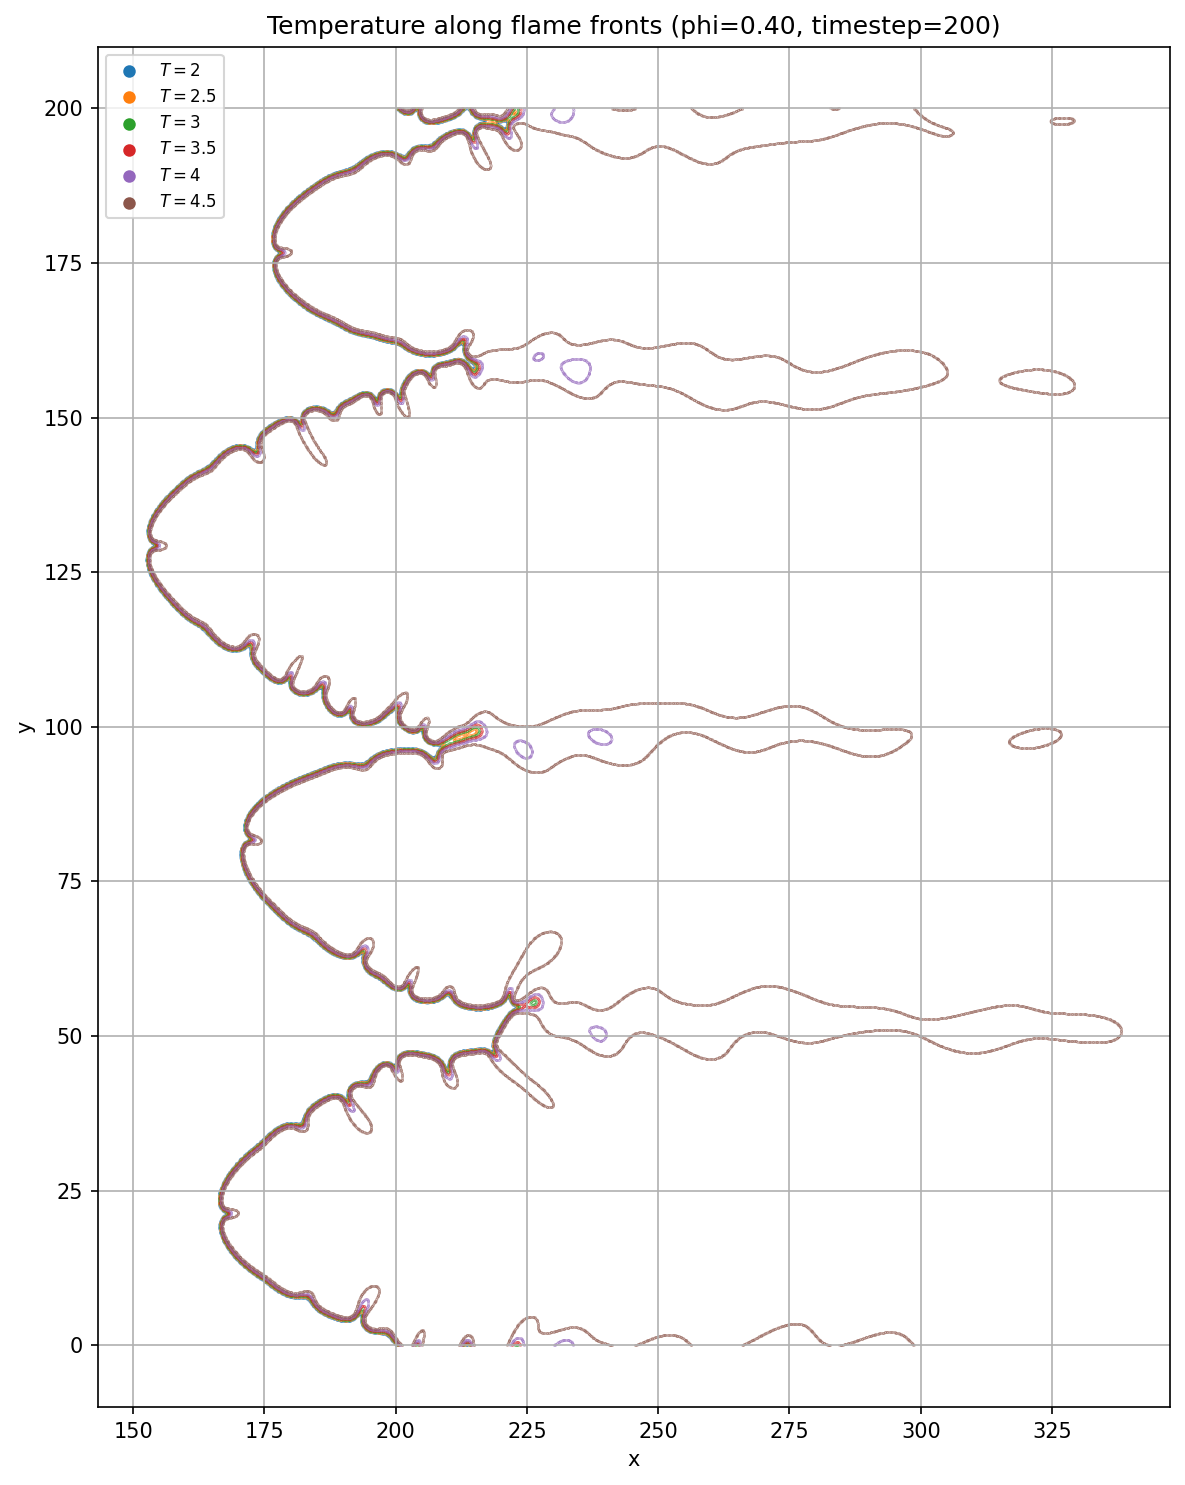

In [28]:
SCALARS = [
    "H2",
    "O2",
    "H2O",
    "H",
    "O",
    "OH",
    "HO2",
    "H2O2",
    "N2",
    "HRR",
    "curvature",
    "stretch_rate",
    "DW_FDS",
    "abs_flame_prop_vel_normal",
    "u_n",
    "u_t",
    "strain_rate",
    "tangential_strain_rate",
    "normal_strain_rate",
    "density_ratio_sigma",
    "gradT", "gradT_normal",
    "total_heat_conduction",
    "heat_conduction_normal",
    "heat_conduction_tangential",
    "FDS_src_term",
    "FDS_diffusion_term",
    "FDS_diff_velocity_term",
    "H2_diffusion_total",
    "O2_diffusion_total",
    "H_diffusion_total",
    "vorticity",
]

CANTERA_INPUTS = ["../chemical_mech/BurkeH2.yaml", None, T_REF, P_REF]

# ============================================================
# Case (new I/O)
# ============================================================



def _case_paths(case: Case, data_base_dir: Path, isocontour_base_dir: Path, iso: float):
    """
    Compatibility helper:
    - If your Case already has helper methods, use them.
    - Else fall back to the exact naming convention you were using before.
    """
    # --- Preferred: Case provides helpers ---
    if hasattr(case, "data_folder") and callable(getattr(case, "data_folder")):
        folder_name = case.data_folder(data_base_dir)
    else:
        # Fallback to old convention
        suffix = "h400x{}_ref".format(case.lat_size)
        if getattr(case, "soret_term", False) and getattr(case, "soret_positive", False):
            suffix = f"h400x{case.lat_size}_ref_Soret_positive"
        elif getattr(case, "soret_term", False):
            suffix = f"h400x{case.lat_size}_ref_Soret"
        folder_name = data_base_dir / f"phi{case.phi:.2f}" / suffix
        if getattr(case, "multiple_runs", False):
            folder_name = folder_name / f"RUN0{getattr(case, 'n_run', 0)}"

    if hasattr(case, "fronts_folder") and callable(getattr(case, "fronts_folder")):
        save_dir = case.fronts_folder(isocontour_base_dir)
    else:
        # Fallback to old convention
        suffix = "h400x{}_ref".format(case.lat_size)
        if getattr(case, "soret_term", False) and getattr(case, "soret_positive", False):
            suffix = f"h400x{case.lat_size}_ref_Soret_positive"
        elif getattr(case, "soret_term", False):
            suffix = f"h400x{case.lat_size}_ref_Soret"
        save_dir = isocontour_base_dir / f"phi{case.phi:.2f}" / suffix
        if getattr(case, "multiple_runs", False):
            save_dir = save_dir / f"RUN0{getattr(case, 'n_run', 0)}"

    # output filename/path
    if hasattr(case, "front_path") and callable(getattr(case, "front_path")):
        out_path = case.front_path(isocontour_base_dir, float(iso))
    else:
        if getattr(case, "post", False):
            fname = f"extracted_flame_front_post_{case.time_step}_iso_{float(iso)}.csv"
        else:
            fname = f"extracted_flame_front_{case.time_step}_iso_{float(iso)}.csv"
        out_path = save_dir / fname

    return folder_name, save_dir, out_path


comm = MPI.COMM_WORLD
rank = comm.rank

if MULTI_TIME_STEP:
    for TIME_STEP in range(TIME_STEP_START, TIME_STEP_END+1):
        # Minimal Case (as per your template)
        case = Case(
            base_dir=ISOCONTOUR_BASE_DIR,  # not used for extraction, but part of the unified convention
            phi=PHI,
            lat_size=LAT_SIZE,
            time_step=TIME_STEP,
            post=POST,
        )
        # derive paths using unified Case logic
        folder_name, save_dir, _ = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, ISOLEVELS[0])

        # Create output directory on rank 0
        if rank == 0:
            save_dir.mkdir(parents=True, exist_ok=True)

        # Create dataset
        ds = SEMDataset(
            file_name=FILE_NAME,
            folder_name=str(folder_name),
            time_step=case.time_step,
            comm=comm,
            scalar_names=SCALARS,
        )

        # Create dataframe (as in your original script)
        df = ds.create_dataframe(
            compute_vel_jacobian=COMP_VEL_JACOBIAN,
            compute_vel_hessian=COMP_VEL_HESSIAN,
            compute_reaction_rates=COMP_REACTION_RATES,
            compute_T_grad=COMP_T_GRAD,
            compute_curv_grad=COMP_CURV_GRAD,
            cantera_inputs=CANTERA_INPUTS,
        )

        # Plot on rank 0 only
        if rank == 0:
            fig, ax = plt.subplots(figsize=(8, 10), dpi=150)

        # Extract + save + plot (rank 0 handles IO/plotting)
        for iso in ISOLEVELS:
            front = ds.extract_flame_front(c_level=iso)

            if rank == 0:
                _, save_dir, out_path = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, float(iso))
                front.to_csv(out_path, index=False)

                ax.scatter(
                    front["x"],
                    front["y"],
                    s=0.01,
                    alpha=1.0,
                    label=fr"$T={iso}$",
                )

        if rank == 0:
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_title(f"Temperature along flame fronts (phi={PHI:.2f}, timestep={TIME_STEP})")
            ax.legend(markerscale=2, fontsize=8)
            ax.grid(True)
            plt.tight_layout()
            plt.show()
else:
# Minimal Case (as per your template)
    case = Case(
        base_dir=ISOCONTOUR_BASE_DIR,  # not used for extraction, but part of the unified convention
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=TIME_STEP,
        post=POST,
    )
    # derive paths using unified Case logic
    folder_name, save_dir, _ = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, ISOLEVELS[0])

    # Create output directory on rank 0
    if rank == 0:
        save_dir.mkdir(parents=True, exist_ok=True)

    # Create dataset
    ds = SEMDataset(
        file_name=FILE_NAME,
        folder_name=str(folder_name),
        time_step=case.time_step,
        comm=comm,
        scalar_names=SCALARS,
    )

    # Create dataframe (as in your original script)
    df = ds.create_dataframe(
        compute_vel_jacobian=COMP_VEL_JACOBIAN,
        compute_vel_hessian=COMP_VEL_HESSIAN,
        compute_reaction_rates=COMP_REACTION_RATES,
        compute_T_grad=COMP_T_GRAD,
        compute_curv_grad=COMP_CURV_GRAD,
        compute_local_vel_jacobian=COMP_LOCAL_VEL_JACOBIAN,
        cantera_inputs=CANTERA_INPUTS,
    )

    # Plot on rank 0 only
    if rank == 0:
        fig, ax = plt.subplots(figsize=(8, 10), dpi=150)

    # Extract + save + plot (rank 0 handles IO/plotting)
    for iso in ISOLEVELS:
        front = ds.extract_flame_front(c_level=iso)

        if rank == 0:
            _, save_dir, out_path = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, float(iso))
            front.to_csv(out_path, index=False)

            ax.scatter(
                front["x"],
                front["y"],
                s=0.01,
                alpha=1.0,
                label=fr"$T={iso}$",
            )

    if rank == 0:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Temperature along flame fronts (phi={PHI:.2f}, timestep={TIME_STEP})")
        ax.legend(markerscale=50, fontsize=8)
        ax.grid(True)
        plt.tight_layout()
        plt.show()

In [22]:
print(len(ds.fld.fields["scal"][31]))

50840


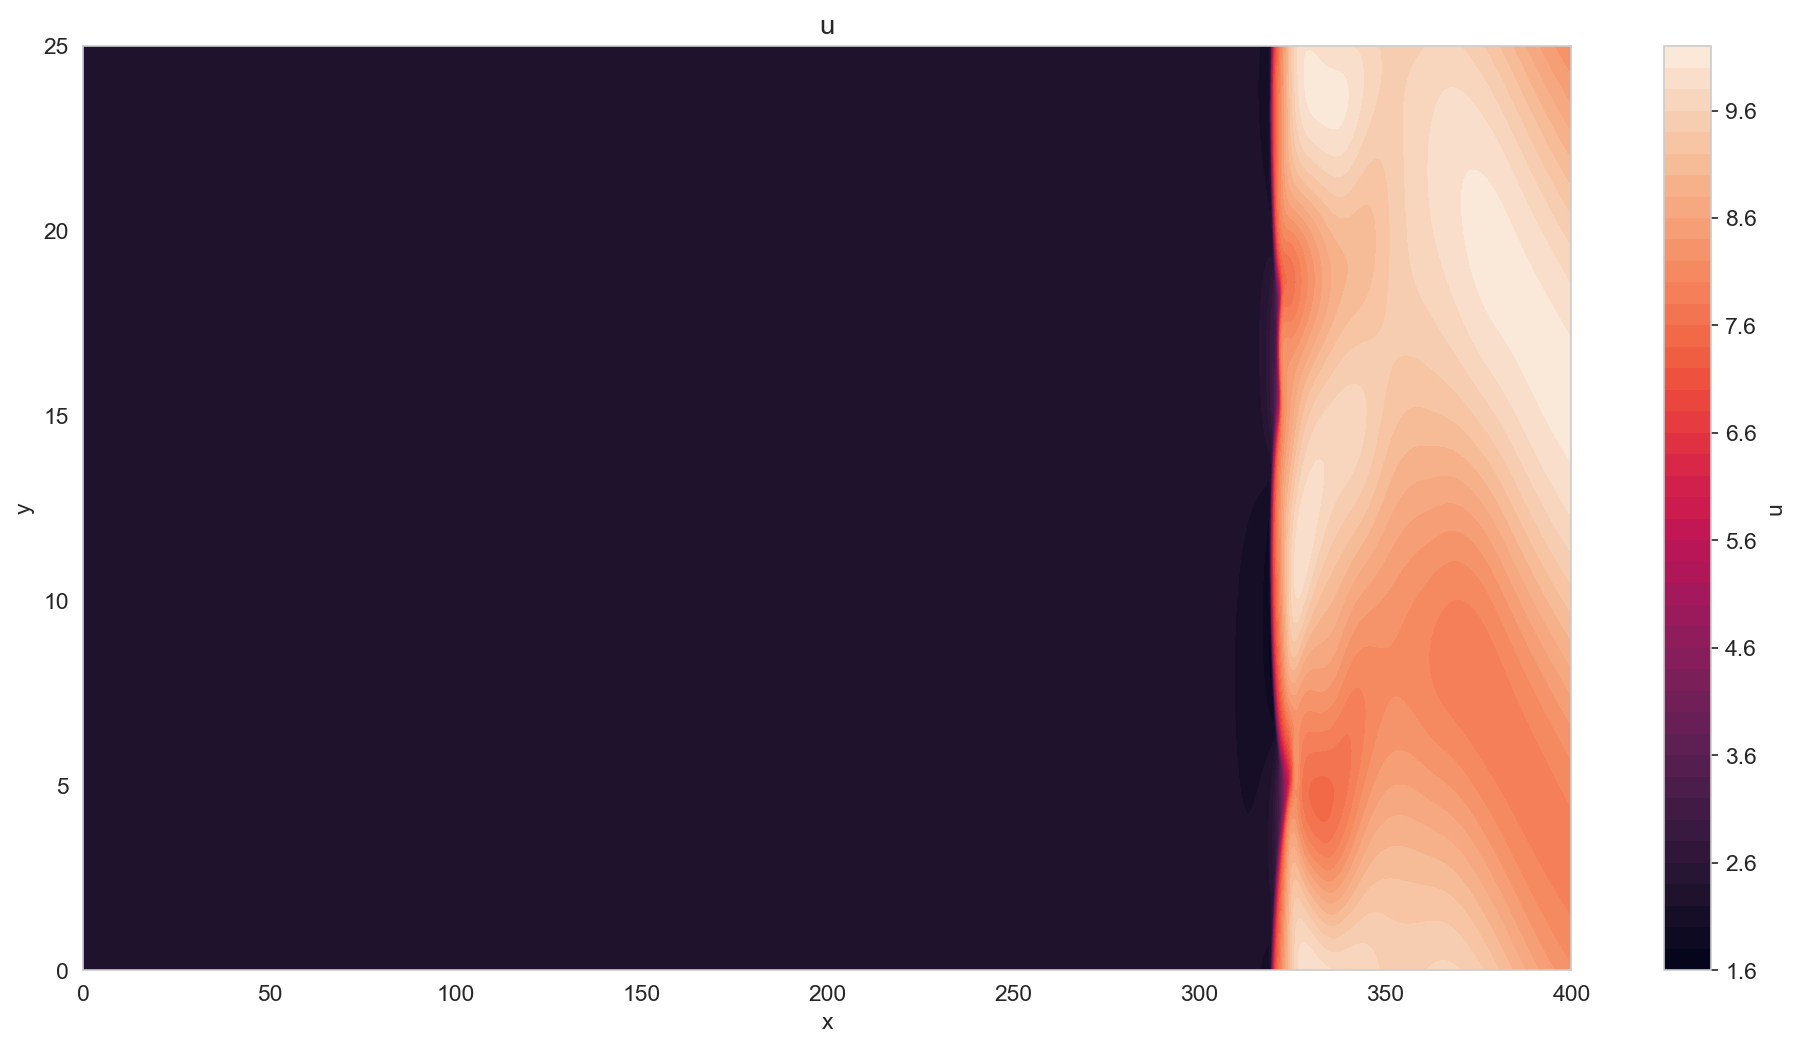

In [12]:
plot_var = "u"
df_sub = df
plt.figure(figsize=(16, 8))
cf = plt.tricontourf(
    df_sub["x"], df_sub["y"], df_sub[plot_var],
    levels=50,
)
plt.xlabel("x")
plt.ylabel("y")
plt.title(str(plot_var))
plt.colorbar(cf, label=plot_var)
plt.show()